In [1]:
import calendar
import datetime
from datetime import date
from typing import List

import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astral import LocationInfo
from astral.sun import sun
from dateutil.relativedelta import TH, relativedelta
from featuretools.primitives import Day, Hour, Minute, Month, Weekday, Year
from scipy.optimize import minimize
from scipy.stats import boxcox, normaltest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, minmax_scale
from sktime._contrib.shapelets import ContractedShapeletTransform
from sktime.datasets import load_arrow_head
from sktime.datatypes._panel._convert import from_nested_to_2d_array
from sktime.transformations.panel.rocket import Rocket
from tsfresh.feature_extraction import ComprehensiveFCParameters, extract_features
from workalendar.europe.united_kingdom import UnitedKingdom
from workalendar.usa import California

# Log and power transformations

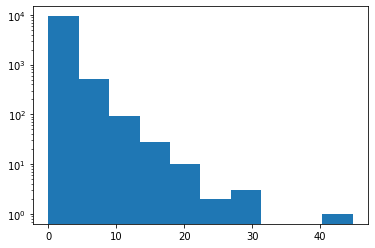

In [2]:
np.random.seed(0)
pts = 10000
vals = np.random.lognormal(0, 1.0, pts)
_ = plt.hist(vals, log=True)

In [3]:
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1, 1))
_, p = normaltest(
    vals_ss.squeeze()
)  # Check if data is normal when standard scaling (it's not)
print(f"significance: {p:.2f}")

significance: 0.00


In [4]:
vals_mm = minmax_scale(vals)
_, p = normaltest(
    vals_mm.squeeze()
)  # Check if data is normal when minmax scaling (it's not)
print(f"significance: {p:.2f}")

significance: 0.00


In [5]:
log_transformed = np.log(vals)  # log-transform
_, p = normaltest(log_transformed)  # Now data is normal
print(f"significance: {p:.2f}")

significance: 0.46


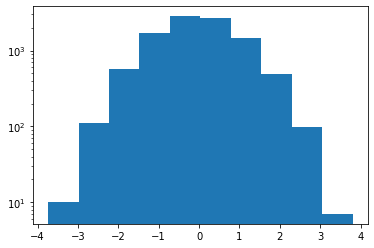

In [6]:
_ = plt.hist(log_transformed, log=True)

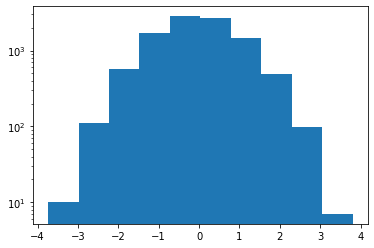

In [7]:
vals_bc = boxcox(vals, 0.0)  # Box-Cox with lambda=0 is the same as log transform
_ = plt.hist(vals_bc, log=True)

# Imputation

In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
SimpleImputer()
df = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(df))

[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


# Holidays

In [9]:
UnitedKingdom().holidays()

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 3), 'New Year shift'),
 (datetime.date(2022, 4, 15), 'Good Friday'),
 (datetime.date(2022, 4, 17), 'Easter Sunday'),
 (datetime.date(2022, 4, 18), 'Easter Monday'),
 (datetime.date(2022, 5, 2), 'Early May Bank Holiday'),
 (datetime.date(2022, 6, 2), 'Spring Bank Holiday'),
 (datetime.date(2022, 6, 3), 'Queen’s Platinum Jubilee bank holiday'),
 (datetime.date(2022, 8, 29), 'Late Summer Bank Holiday'),
 (datetime.date(2022, 12, 25), 'Christmas Day'),
 (datetime.date(2022, 12, 26), 'Boxing Day'),
 (datetime.date(2022, 12, 26), 'Christmas Shift'),
 (datetime.date(2022, 12, 27), 'Boxing Day Shift')]

In [10]:
def create_custom_holidays(year: int) -> List:
    custom_holidays = California().holidays()
    custom_holidays.append(
        (
            (
                datetime.datetime(year, 11, 1)
                + relativedelta(weekday=TH(+4))
                + datetime.timedelta(days=1)
            ).date(),
            "Black Friday",
        )
    )
    return {k: v for (k, v) in custom_holidays}


custom_holidays = create_custom_holidays(2021)
custom_holidays

{datetime.date(2021, 12, 31): 'New year (Observed)',
 datetime.date(2022, 1, 1): 'New year',
 datetime.date(2022, 1, 17): 'Birthday of Martin Luther King, Jr.',
 datetime.date(2022, 2, 21): "Washington's Birthday",
 datetime.date(2022, 3, 31): 'Cesar Chavez Day',
 datetime.date(2022, 5, 30): 'Memorial Day',
 datetime.date(2022, 7, 4): 'Independence Day',
 datetime.date(2022, 9, 5): 'Labor Day',
 datetime.date(2022, 11, 11): 'Veterans Day',
 datetime.date(2022, 11, 24): 'Thanksgiving Day',
 datetime.date(2022, 11, 25): 'Thanksgiving Friday',
 datetime.date(2022, 12, 25): 'Christmas Day',
 datetime.date(2022, 12, 26): 'Christmas Day (Observed)',
 datetime.date(2021, 11, 26): 'Black Friday'}

In [11]:
def is_holiday(current_date: datetime.date):
    """Determine if we have a holiday."""
    return custom_holidays.get(current_date, False)


today = datetime.date(2021, 4, 11)
is_holiday(today)

False

# Date Annotation

In [12]:
calendar.monthrange(2021, 1)


def year_anchor(current_date: datetime.date):
    return (
        (current_date - date(current_date.year, 1, 1)).days,
        (date(current_date.year, 12, 31) - current_date).days,
    )


year_anchor(today)

(100, 264)

In [13]:
def month_anchor(current_date: datetime.date):
    last_day = calendar.monthrange(current_date.year, current_date.month)[0]
    return (
        (current_date - datetime.date(current_date.year, current_date.month, 1)).days,
        (
            current_date
            - datetime.date(current_date.year, current_date.month, last_day)
        ).days,
    )


month_anchor(today)

(10, 8)

# Paydays

In [14]:
def get_last_friday(current_date: datetime.date, weekday=calendar.FRIDAY):
    return max(
        week[weekday]
        for week in calendar.monthcalendar(current_date.year, current_date.month)
    )


get_last_friday(today)

30

# Seasons

In [15]:
YEAR = 2021
seasons = [
    ("winter", (date(YEAR, 1, 1), date(YEAR, 3, 20))),
    ("spring", (date(YEAR, 3, 21), date(YEAR, 6, 20))),
    ("summer", (date(YEAR, 6, 21), date(YEAR, 9, 22))),
    ("autumn", (date(YEAR, 9, 23), date(YEAR, 12, 20))),
    ("winter", (date(YEAR, 12, 21), date(YEAR, 12, 31))),
]


def is_in_interval(current_date: datetime.date, seasons):
    return next(
        season
        for season, (start, end) in seasons
        if start <= current_date.replace(year=YEAR) <= end
    )


is_in_interval(today, seasons)

'spring'

# The Sun and Moon

In [16]:
CITY = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)


def get_sunrise_dusk(current_date: datetime.date, city_name="London"):
    s = sun(CITY.observer, date=current_date)
    sunrise = s["sunrise"]
    dusk = s["dusk"]
    return (sunrise - dusk).seconds / 3600


get_sunrise_dusk(today)

9.788055555555555

# Business Days

In [17]:
def get_business_days(current_date: datetime.date):
    last_day = calendar.monthrange(current_date.year, current_date.month)[1]
    rng = pd.date_range(current_date.replace(day=1), periods=last_day, freq="D")
    business_days = pd.bdate_range(rng[0], rng[-1])
    return len(business_days), last_day - len(business_days)


get_business_days(date.today())

(23, 8)

# Automated Feature Extraction

In [18]:
data = pd.DataFrame(
    {
        "Time": [
            "2014-01-01 01:41:50",
            "2014-01-01 02:06:50",
            "2014-01-01 02:31:50",
            "2014-01-01 02:56:50",
            "2014-01-01 03:21:50",
        ],
        "Target": [0, 0, 0, 0, 1],
    }
)
data["index"] = data.index
es = ft.EntitySet(id="es")
es.add_dataframe(
    dataframe_name="data", index="index", dataframe=data, time_index="Time"
)
fm, features = ft.dfs(
    dataframes={"data": data},
    entityset=es,
    target_dataframe_name="data",
    trans_primitives=[Minute, Hour, Day, Month, Year, Weekday],
)
fm

C:\Users\Admin\Desktop\ml-time-series-book\venv\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:161: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


,Target,DAY(Time),HOUR(Time),MINUTE(Time),MONTH(Time),WEEKDAY(Time),YEAR(Time)
index,,,,,,,
0,0,1,1,41,1,2,2014
1,0,1,2,6,1,2,2014
2,0,1,2,31,1,2,2014
3,0,1,2,56,1,2,2014
4,1,1,3,21,1,2,2014


In [19]:
data["index"] = 0
settings = ComprehensiveFCParameters()
ef = extract_features(
    data, column_id="index", column_sort="Time", default_fc_parameters=settings
)
print(ef.shape)
ef

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]

(1, 789)


,Target__variance_larger_than_standard_deviation,Target__has_duplicate_max,Target__has_duplicate_min,Target__has_duplicate,Target__sum_values,Target__abs_energy,Target__mean_abs_change,Target__mean_change,Target__mean_second_derivative_central,Target__median,...,Target__permutation_entropy__dimension_6__tau_1,Target__permutation_entropy__dimension_7__tau_1,Target__query_similarity_count__query_None__threshold_0.0,"Target__matrix_profile__feature_""min""__threshold_0.98","Target__matrix_profile__feature_""max""__threshold_0.98","Target__matrix_profile__feature_""mean""__threshold_0.98","Target__matrix_profile__feature_""median""__threshold_0.98","Target__matrix_profile__feature_""25""__threshold_0.98","Target__matrix_profile__feature_""75""__threshold_0.98",Target__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,1.0,1.0,1.0,1.0,0.25,0.25,0.166667,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ROCKET

In [20]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
from_nested_to_2d_array(X_train).head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
0,-1.963009,-1.957825,-1.956145,-1.938289,-1.896657,-1.869857,-1.838705,-1.812289,-1.736433,-1.673329,...,-1.583857,-1.655329,-1.719153,-1.750881,-1.796273,-1.841345,-1.884289,-1.905393,-1.923905,-1.909153
1,-1.774571,-1.774036,-1.776586,-1.730749,-1.696268,-1.657377,-1.636227,-1.609807,-1.543439,-1.486174,...,-1.471688,-1.484666,-1.539972,-1.590150,-1.635663,-1.639989,-1.678683,-1.729227,-1.775670,-1.789324
2,-1.866021,-1.841991,-1.835025,-1.811902,-1.764390,-1.707687,-1.648280,-1.582643,-1.531502,-1.493609,...,-1.584132,-1.652337,-1.684565,-1.743972,-1.799117,-1.829069,-1.875828,-1.862512,-1.863368,-1.846493
3,-2.073758,-2.073301,-2.044607,-2.038346,-1.959043,-1.874494,-1.805619,-1.731043,-1.712653,-1.628022,...,-1.678942,-1.743732,-1.819801,-1.858136,-1.886146,-1.951247,-2.012927,-2.026963,-2.073405,-2.075292
4,-1.746255,-1.741263,-1.722741,-1.698640,-1.677223,-1.630356,-1.579440,-1.551225,-1.473980,-1.459377,...,-1.547111,-1.607101,-1.635137,-1.686346,-1.691274,-1.716886,-1.740726,-1.743442,-1.762729,-1.763428


In [21]:
rocket = Rocket(num_kernels=1000)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)
X_train_transform

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.481633,0.997700,1.000000,4.295828,0.496644,6.458947,0.462151,4.826001,0.486486,3.044656,...,0.509960,3.509021,0.666667,4.019807,0.593625,5.087722,0.293532,1.679802,0.551724,3.837600
1,0.493878,0.848099,1.000000,4.835632,0.483221,6.818696,0.454183,3.710492,0.502703,2.804500,...,0.505976,3.168415,0.641791,3.729762,0.565737,5.538860,0.303483,1.532259,0.561576,3.334343
2,0.493878,0.912041,1.000000,4.738617,0.496644,7.001227,0.470120,4.158290,0.502703,2.863889,...,0.505976,3.463274,0.636816,4.210098,0.585657,5.116067,0.298507,1.841081,0.566502,3.559919
3,0.493878,1.154919,1.000000,4.469446,0.557047,6.218636,0.482072,4.036448,0.443243,3.367300,...,0.494024,3.741800,0.597015,3.955438,0.637450,4.365958,0.393035,1.798537,0.566502,3.867207
4,0.497959,0.775507,1.000000,4.823087,0.476510,6.892928,0.458167,3.519438,0.508108,2.905782,...,0.490040,3.275913,0.651741,3.609245,0.581673,5.682102,0.348259,1.427287,0.600985,3.107342
5,0.506122,0.922161,1.000000,4.842749,0.476510,7.388381,0.398406,4.196338,0.513514,2.784598,...,0.478088,3.619286,0.676617,4.121160,0.577689,5.432939,0.238806,1.791666,0.586207,3.722395
6,0.489796,1.097210,1.000000,5.275804,0.456376,5.687185,0.446215,5.331196,0.583784,3.282739,...,0.501992,3.728379,0.671642,4.458224,0.545817,4.326235,0.308458,2.030640,0.591133,3.835039
7,0.526531,0.771715,1.000000,4.576155,0.489933,6.536970,0.474104,3.566784,0.524324,2.773895,...,0.470120,3.040396,0.641791,3.546776,0.593625,6.031337,0.368159,1.300458,0.566502,3.133677
8,0.493878,1.032971,1.000000,4.739352,0.489933,6.816058,0.478088,4.023141,0.508108,2.721077,...,0.478088,3.142554,0.631841,3.981871,0.577689,5.215581,0.303483,1.566705,0.551724,3.531481
9,0.514286,1.271336,1.000000,4.210720,0.570470,5.476878,0.478088,5.263391,0.427027,3.255474,...,0.482072,3.929983,0.606965,4.377501,0.697211,4.030335,0.363184,1.710515,0.536946,4.130424


# Shapelets

In [22]:
shapelets_transform = ContractedShapeletTransform(
    time_contract_in_mins=1,
    num_candidates_to_sample_per_case=10,
    verbose=0,
)
shapelets_transform.fit(X_train, y_train)

ContractedShapeletTransform(num_candidates_to_sample_per_case=10,
                            time_contract_in_mins=1)

In [23]:
X_train_transform = shapelets_transform.transform(X_train)
X_train_transform